In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

In [51]:
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

In [2]:
import torchvision
import torch

In [3]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

In [4]:
retina.load_state_dict(torch.load(f'retina_30.pt'))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

In [6]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #select idx which meets the threshold
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [107]:
player = cv2.VideoCapture('/media/data/chitb/facemask/connect_webcam/video-1641982054.mp4')
player.isOpened()

True

In [108]:
i = 0
while i < 290:
    ret, frame = player.read()
    i += 1


In [109]:
	
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [110]:
frame = Image.fromarray(gray)

In [111]:
to_tensor = torchvision.transforms.ToTensor()
img = to_tensor(frame)

In [112]:
img.shape

torch.Size([3, 720, 1080])

In [68]:
ret = True
i =  0
while ret:
    ret, frame = player.read()
    if not ret:
        break
    img = to_tensor(frame)


    retina.eval()
    preds = make_prediction(retina, [img.float().cuda()], 0.6)
    preds = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds]
    if i == 295:
        break
    i += 1
print(i)


295


In [113]:
# #use  image
# img = to_tensor(Image.open('/media/data/chitb/facemask/connect_webcam/Screenshot 2022-01-14 145350.png').convert('RGB'))


retina.eval()
preds = make_prediction(retina, [img.float().cuda()], 0.5)
preds = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds]

In [114]:
preds[0]['labels']

tensor([2, 0])

In [55]:
a = dict([('a', 2), ('b', 3), ('c', 4), ('d', 5)])
type(a.items())

dict_items

In [49]:
import matplotlib.pyplot as plt
import time

In [ ]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

pos = 0
img, rects = plot_image_from_output(img, preds[0])
axes[(pos)//2, 1-((pos)%2)].imshow(img)
for rect in rects:
    axes[(pos)//2, 1-((pos)%2)].add_patch(rect)

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])


# for idx, ax in enumerate(axes[0]):
#     ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

In [127]:
class Gen_output:
    def __init__(self, input_video, output_video, model_path):
        self.input_video = input_video
        self.output_video = output_video 
        self.model_path = model_path
    def load_model(self, model_path):
        retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)
        retina.load_state_dict(torch.load(self.model_path))
        return retina
    def plot_boxes(self, results, frame):
        """
        plots boxes and labels on frame.
        :param results: inferences made by model
        :param frame: frame on which to  make the plots
        :return: new frame with boxes and labels plotted.
        """

        
        cord, scores, labels  = results.values()
        cord, scores, labels = cord.detach().numpy(), scores.detach().numpy(), labels.numpy()
        n = len(labels)
        x_shape, y_shape = frame.shape[1], frame.shape[0]
        for i in range(n):
            row = cord[i]
            x1, y1, x2, y2 = int(row[0]), int(row[1]), int(row[2]), int(row[3])
            bgr = (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), bgr, 1)
            # label = f"{int(row[4]*100)}"
            cv2.putText(frame, f"prob: {scores}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
            cv2.putText(frame, f"Total Targets: {n}", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 253, 0), 2)
            if labels[i] == 1:
                cv2.putText(frame, 'True', (90, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else:
                cv2.putText(frame, 'NGU VL', (90, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


        return frame
        

    def __call__(self):
        player = cv2.VideoCapture(self.input_video)
        x_shape = int(player.get(cv2.CAP_PROP_FRAME_WIDTH))
        y_shape = int(player.get(cv2.CAP_PROP_FRAME_HEIGHT))
        print(x_shape, y_shape)
        four_cc = cv2.VideoWriter_fourcc(*"MJPG")
        out = cv2.VideoWriter(self.output_video, four_cc, 20, (x_shape, y_shape))
        fc = 0
        fps = 0
        tfc = int(player.get(cv2.CAP_PROP_FRAME_COUNT))
        tfcc = 0
        retina = self.load_model(self.model_path).cuda()
        retina.eval()
        to_tensor = torchvision.transforms.ToTensor()
        while True:
            fc += 1
            start_time = time.time()
            ret, frame = player.read()
            
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # results = self.score_frame(frame)
            imgs = to_tensor(frame).float().cuda()
            preds = make_prediction(retina, [imgs], threshold=0.7)
            preds = [{k: v.to('cpu') for k, v in t.items()} for t in preds]
            results = preds[0]
            # cord, scores, labels  = results.values()
            # print(cord.detach().numpy(), scores.detach().numpy(), labels.numpy())
            
            # break

            
            
            frame = self.plot_boxes(results, frame)
            end_time = time.time()
            fps += 1/np.round(end_time - start_time, 3)
            if fc == 10:
                fps = int(fps / 10)
                tfcc += fc
                fc = 0
                per_com = int(tfcc / tfc * 100)
                print(f"Frames Per Second : {fps} || Percentage Parsed : {per_com}")
            out.write(frame)
        player.release()
        

In [128]:
gen = Gen_output('/media/data/chitb/facemask/connect_webcam/video-1641982054.mp4', '/media/data/chitb/facemask/connect_webcam/output.avi', '/media/data/chitb/facemask/connect_webcam/retina_30.pt')

In [129]:
frame = gen()

1080 720
Frames Per Second : 17 || Percentage Parsed : 3
Frames Per Second : 20 || Percentage Parsed : 6
Frames Per Second : 20 || Percentage Parsed : 9
Frames Per Second : 20 || Percentage Parsed : 12
Frames Per Second : 20 || Percentage Parsed : 16
Frames Per Second : 20 || Percentage Parsed : 19
Frames Per Second : 20 || Percentage Parsed : 22
Frames Per Second : 20 || Percentage Parsed : 25
Frames Per Second : 20 || Percentage Parsed : 29
Frames Per Second : 20 || Percentage Parsed : 32
Frames Per Second : 20 || Percentage Parsed : 35
Frames Per Second : 20 || Percentage Parsed : 38
Frames Per Second : 20 || Percentage Parsed : 42
Frames Per Second : 20 || Percentage Parsed : 45
Frames Per Second : 20 || Percentage Parsed : 48
Frames Per Second : 20 || Percentage Parsed : 51
Frames Per Second : 20 || Percentage Parsed : 55
Frames Per Second : 20 || Percentage Parsed : 58
Frames Per Second : 20 || Percentage Parsed : 61
Frames Per Second : 20 || Percentage Parsed : 64
Frames Per Sec

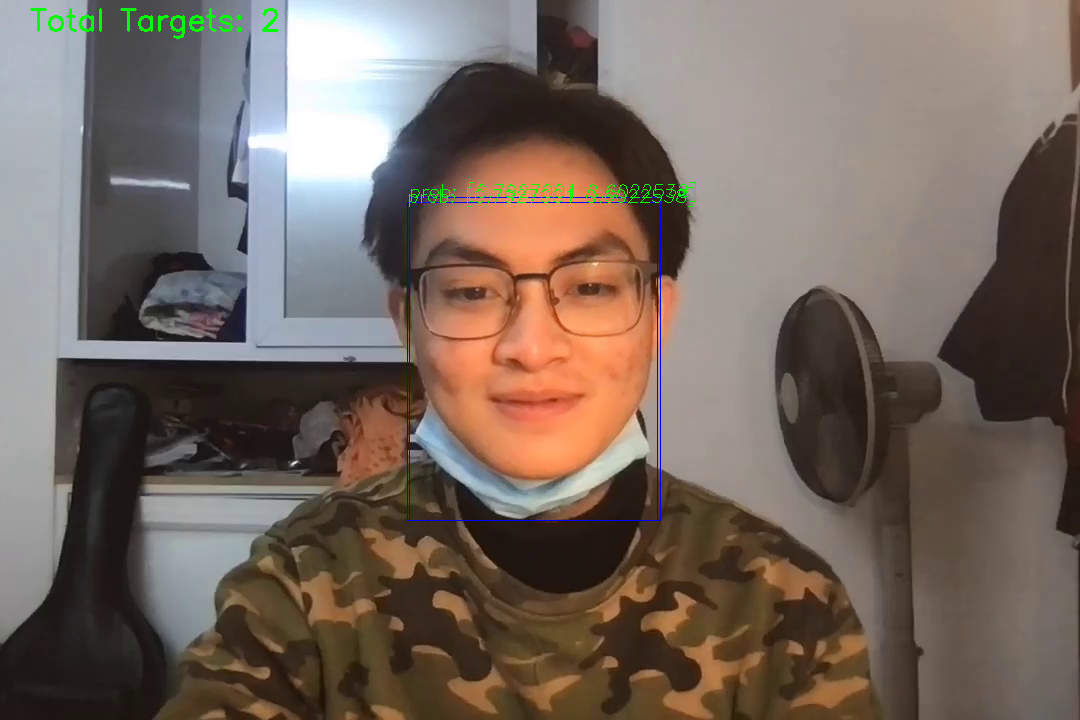

In [119]:
Image.fromarray(frame)